# Functional Comparison of ASN with WS and C. Elegans

This notebook generates 24 different ASN networks with 300 nodes, each of which has differing parameters (Average Path length, Wire Dispersion and Centroid Dispersion). 

We then find the average degree for each ASN network, and use that as 2k to generate corresponding grid-like, small-world and random Watts-Strogatz networks.

We also load a sample C. Elegans network for comparison.

In [1]:
cd "C:\Users\aloe8475\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame"

C:\Users\aloe8475\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame


In [2]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

warnings.filterwarnings('ignore')

## Generate 300nw ASN + C. Elegans:

In [3]:
cElegans=loadmat(r"C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Data\Organic Networks Connectomes\celegans277neurons.mat")

In [4]:
#set up dictionary for celegans:
Elegans={'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [ ]:
elegansMat=cElegans['celegans277matrix']
elegansGraph = nx.from_numpy_array(elegansMat)
Elegans['adj_matrix']=elegansMat
Elegans['G']=elegansGraph

In [5]:
wires.generate_wires_distribution

<function edamame.core.wires.generate_wires_distribution(number_of_wires=1500, wire_av_length=14.0, wire_dispersion=5.0, centroid_dispersion=1200.0, gennorm_shape=5, Lx=3000.0, Ly=3000.0, this_seed=None)>

In [6]:
#Set Paramaters for network generation: Centroid Dispersion, Wire Dispersion + Length of Wires
this_seed=1779#np.random.randint(10000)#5772
params={'Centroid':np.arange(100,400,50),'Wire Dispersion':[1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0],'Length':np.arange(100,300,25)}
numNetworks=len(params['Centroid'])+len(params['Wire Dispersion'])+len(params['Length']) #all parameters)
ASN300=[None]*numNetworks

#Generate networks based on params 
for i in range(numNetworks):
    #loop through different parameter sets:
    if i < len(params['Centroid']):
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],wire_av_length=100)
        count = 0
        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,wire_dispersion=10,centroid_dispersion=params['Centroid'][i],this_seed=randSeed2,wire_av_length=100)#, max_iters=2)
    elif i >= len(params['Centroid']) and i < len(params['Centroid'])+len(params['Wire Dispersion']):
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-len(params['Centroid'])],wire_av_length=100)
        count = 0;
        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,centroid_dispersion=350,wire_dispersion=params['Wire Dispersion'][i-6],this_seed=randSeed2,wire_av_length=100)#, max_iters=2)
                    
    else:
        ASN300[i]=wires.generate_wires_distribution(300,this_seed=this_seed,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-(len(params['Centroid'])+len(params['Wire Dispersion']))],)
        count = 0;
        while ASN300[i]==None: #make sure the networks aren't empty
            count=count+1
            randSeed2=np.random.randint(count,100000) #size = number of networks of each size
            ASN300[i]=wires.generate_wires_distribution(300,centroid_dispersion=350,wire_dispersion=10,wire_av_length=params['Length'][i-16],this_seed=randSeed2)#, max_iters=2) 

In [ ]:
#set up accuracy dictionary for ASN
for i in range(len(ASN300)):
    ASN300[i].update({'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]}})

In [7]:
this_seed

1779

In [8]:
# this_seed2=700
# ASN100=edamame.core.generateNetwork(100,this_seed=this_seed2)
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [9]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

In [13]:
# nwEdges100=np.array(np.sum(ASN100['adj_matrix'])/2)

#Detect junctions, create adj matrix and graph, and store number of junctions
nwEdges300=[None]*len(ASN300)
for i in range(len(ASN300)):
    print('Network ' + str(i))
    ASN300[i]=wires.detect_junctions(ASN300[i])
    ASN300[i]=wires.generate_adj_matrix(ASN300[i])
    ASN300[i]=wires.generate_graph(ASN300[i])
    ASN300[i]=select_largest_component_new(ASN300[i])
    nwEdges300[i]=np.array(np.sum(ASN300[i]['adj_matrix'])/2)

2020-03-11 14:50:51,057:INFO:Detecting junctions


Network 0


2020-03-11 14:50:51,811:INFO:Finished detecting junctions
2020-03-11 14:50:51,847:INFO:The largest component has   300 nodes and   5766 edges
2020-03-11 14:50:51,899:INFO:Detecting junctions


Network 1


2020-03-11 14:50:52,589:INFO:Finished detecting junctions
2020-03-11 14:50:52,616:INFO:The largest component has   299 nodes and   2696 edges
2020-03-11 14:50:52,646:INFO:Detecting junctions


Network 2


2020-03-11 14:50:53,291:INFO:Finished detecting junctions
2020-03-11 14:50:53,304:INFO:The largest component has   295 nodes and   1556 edges
2020-03-11 14:50:53,325:INFO:Detecting junctions


Network 3


2020-03-11 14:50:53,930:INFO:Finished detecting junctions
2020-03-11 14:50:53,940:INFO:The largest component has   288 nodes and   1012 edges
2020-03-11 14:50:53,955:INFO:Detecting junctions


Network 4


2020-03-11 14:50:54,447:INFO:Finished detecting junctions
2020-03-11 14:50:54,455:INFO:The largest component has   262 nodes and    660 edges
2020-03-11 14:50:54,467:INFO:Detecting junctions


Network 5


2020-03-11 14:50:54,835:INFO:Finished detecting junctions
2020-03-11 14:50:54,840:INFO:The largest component has   224 nodes and    452 edges
2020-03-11 14:50:54,849:INFO:Detecting junctions


Network 6


2020-03-11 14:50:55,271:INFO:Finished detecting junctions
2020-03-11 14:50:55,277:INFO:The largest component has   241 nodes and    485 edges
2020-03-11 14:50:55,287:INFO:Detecting junctions


Network 7


2020-03-11 14:50:55,698:INFO:Finished detecting junctions
2020-03-11 14:50:55,704:INFO:The largest component has   241 nodes and    486 edges
2020-03-11 14:50:55,713:INFO:Detecting junctions


Network 8


2020-03-11 14:50:56,125:INFO:Finished detecting junctions
2020-03-11 14:50:56,131:INFO:The largest component has   238 nodes and    477 edges
2020-03-11 14:50:56,141:INFO:Detecting junctions


Network 9


2020-03-11 14:50:56,542:INFO:Finished detecting junctions
2020-03-11 14:50:56,551:INFO:The largest component has   238 nodes and    471 edges
2020-03-11 14:50:56,561:INFO:Detecting junctions


Network 10


2020-03-11 14:50:56,935:INFO:Finished detecting junctions
2020-03-11 14:50:56,941:INFO:The largest component has   224 nodes and    452 edges
2020-03-11 14:50:56,951:INFO:Detecting junctions


Network 11


2020-03-11 14:50:57,314:INFO:Finished detecting junctions
2020-03-11 14:50:57,320:INFO:The largest component has   224 nodes and    440 edges
2020-03-11 14:50:57,329:INFO:Detecting junctions


Network 12


2020-03-11 14:50:57,558:INFO:Finished detecting junctions
2020-03-11 14:50:57,563:INFO:The largest component has   179 nodes and    361 edges
2020-03-11 14:50:57,570:INFO:Detecting junctions


Network 13


2020-03-11 14:50:57,922:INFO:Finished detecting junctions
2020-03-11 14:50:57,927:INFO:The largest component has   223 nodes and    434 edges
2020-03-11 14:50:57,936:INFO:Detecting junctions


Network 14


2020-03-11 14:50:58,234:INFO:Finished detecting junctions
2020-03-11 14:50:58,238:INFO:The largest component has   201 nodes and    396 edges
2020-03-11 14:50:58,246:INFO:Detecting junctions
2020-03-11 14:50:58,345:INFO:Finished detecting junctions
2020-03-11 14:50:58,349:INFO:The largest component has   111 nodes and    390 edges
2020-03-11 14:50:58,355:INFO:Detecting junctions


Network 15
Network 16


2020-03-11 14:50:58,709:INFO:Finished detecting junctions
2020-03-11 14:50:58,715:INFO:The largest component has   224 nodes and    452 edges
2020-03-11 14:50:58,724:INFO:Detecting junctions


Network 17


2020-03-11 14:50:59,247:INFO:Finished detecting junctions
2020-03-11 14:50:59,256:INFO:The largest component has   266 nodes and    785 edges
2020-03-11 14:50:59,271:INFO:Detecting junctions


Network 18


2020-03-11 14:50:59,898:INFO:Finished detecting junctions
2020-03-11 14:50:59,908:INFO:The largest component has   291 nodes and   1160 edges
2020-03-11 14:50:59,926:INFO:Detecting junctions


Network 19


2020-03-11 14:51:00,577:INFO:Finished detecting junctions
2020-03-11 14:51:00,598:INFO:The largest component has   295 nodes and   1542 edges
2020-03-11 14:51:00,618:INFO:Detecting junctions


Network 20


2020-03-11 14:51:01,284:INFO:Finished detecting junctions
2020-03-11 14:51:01,300:INFO:The largest component has   295 nodes and   2013 edges
2020-03-11 14:51:01,318:INFO:Detecting junctions


Network 21


2020-03-11 14:51:02,015:INFO:Finished detecting junctions
2020-03-11 14:51:02,034:INFO:The largest component has   299 nodes and   2533 edges
2020-03-11 14:51:02,061:INFO:Detecting junctions


Network 22


2020-03-11 14:51:02,769:INFO:Finished detecting junctions
2020-03-11 14:51:02,794:INFO:The largest component has   300 nodes and   3106 edges
2020-03-11 14:51:02,826:INFO:Detecting junctions


Network 23


2020-03-11 14:51:03,550:INFO:Finished detecting junctions
2020-03-11 14:51:03,575:INFO:The largest component has   300 nodes and   3725 edges


In [14]:
avgDegree300=[None]*len(nwEdges300)
for i in range(len(nwEdges300)):
    avgDegree300[i]=nwEdges300[i]/300
# avgDegree100=nwEdges100/100

In [15]:
# fwASN100=nx.floyd_warshall_numpy(ASN100['G'])
fwASN300=[None]*len(ASN300)
for i in range(len(ASN300)):
    fwASN300[i]=nx.floyd_warshall_numpy(ASN300[i]['G'])

## Generate WS: 

In [16]:
# ws100=[]
ws300=[[None]*2 for i in range(len(ASN300))]
this_seed=np.random.randint(1000) #595
for i in range(len(ASN300)):
    for beta in range(2):
#           print(str(i)+' '+str(beta))
#         ws100.append(nx.watts_strogatz_graph(100,int(np.round(avgDegree100)),beta,seed=this_seed))
        if np.round(avgDegree300[i]) < 1.5:
            k=2
        else:
            k=int(np.round(avgDegree300[i]))
        temp=nx.watts_strogatz_graph(300,k,beta,seed=this_seed)
        ws300[i][beta]=max(connected_component_subgraphs(temp), key=len)

In [ ]:
#set up accuracy dictionary for WS
for i in range(len(ws300)):
    ws300[i].update({'Accuracy':{'Linear Transformation':[],'Mackey Glass':[],'MNIST':[]}})

In [17]:
#export adj matrices to calculate small worldness in matlab:
adj_mats={"AdjMat":[]}
for i in range(len(ASN300)):
    adj_mats['AdjMat'].append(ASN300[i]['adj_matrix'])
savemat(r'C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\300nwASN.mat',adj_mats)

## Graph Theory Measures:

### ASN

In [18]:
for i in range(len(ASN300)):
    ASN300[i].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})

In [19]:
# Small Worldness: 
# ------------------------------------
# CALCULATED IN MATLAB: smallworldness.m 
# found in C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks
# ------------------------------------
temp=loadmat(r'C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\300nwASN_smallworld.mat')
smallworld=temp['smallworld'][0]
del temp

In [20]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = [None]*len(ASN300)
pcoeff= [None]*len(ASN300)
mz= [None]*len(ASN300)

for i in range(len(ASN300)):
    ci[i],q=nct.community_louvain(ASN300[i]['adj_matrix'])
    pcoeff[i]=bct.participation_coef(ASN300[i]['adj_matrix'],ci[i])
    mz[i]=bct.module_degree_zscore(ASN300[i]['adj_matrix'],ci[i])
    ASN300[i]['Graph Theory']['Modularity']=ci[i]
    ASN300[i]['Graph Theory']['PCoeff']=pcoeff[i]
    ASN300[i]['Graph Theory']['MZ']=mz[i]
    ASN300[i]['Graph Theory']['Small World']=smallworld[i]

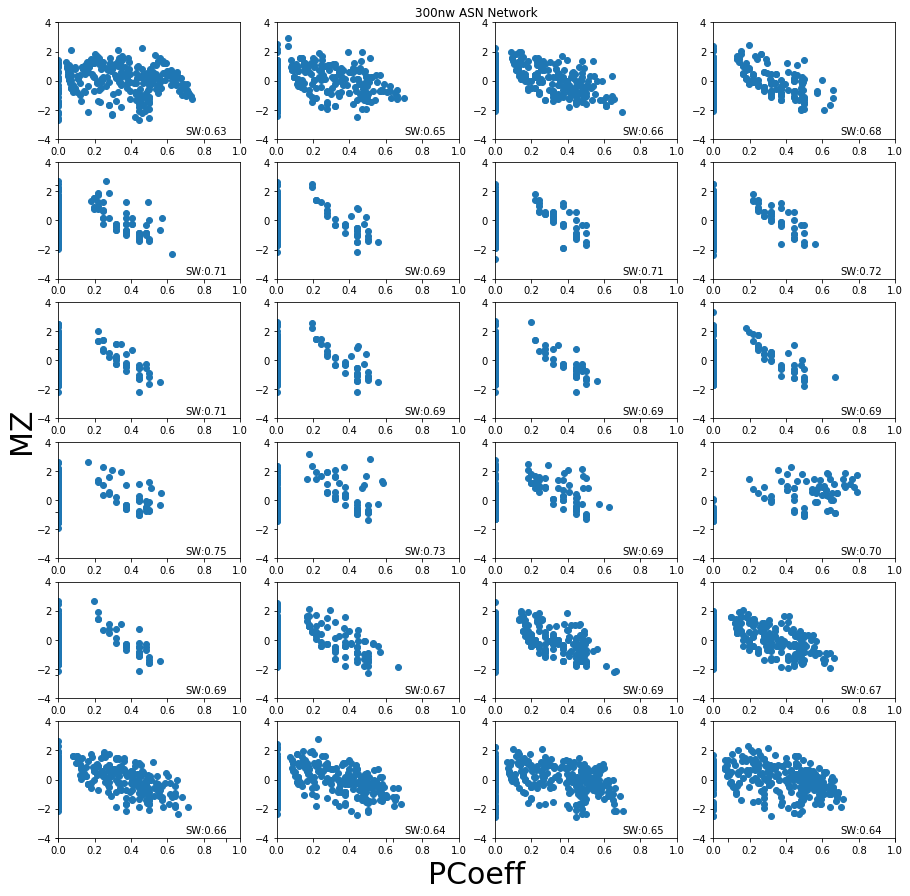

In [21]:
#Plot Participation Coefficient vs MZ
fig1=plt.figure(figsize=(15,15))

ax=[None]*24
axBig = fig1.add_subplot(111)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
plt.title('300nw ASN Network')
plt.xlabel('PCoeff',fontsize=30,labelpad=15)
plt.ylabel('MZ',fontsize=30,labelpad=15)
for i in range(len(ax)):
    ax[i]=fig1.add_subplot(6, 4, i+1)
    plt.scatter(pcoeff[i],mz[i])
    plt.text(0.7,-3.7,'SW:'+"{0:.2f}".format(smallworld[i]))
    ax[i].set_ylim(-4,4)
    ax[i].set_xlim(0,1)

### C. Elegans

In [22]:
#Small world calculated on C Elegans Matrix in smallworld.m in MATLAB
temp=loadmat(r'C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\cElegans_smallworld.mat')
smallworld=temp['cElegansSW'][0]
del temp

In [29]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = []
pcoeff= []
mz= []

ci,q=nct.community_louvain(elegansMat)
pcoeff=bct.participation_coef(elegansMat,ci)
mz=bct.module_degree_zscore(elegansMat,ci)
Elegans['Graph Theory']['MZ']=mz
Elegans['Graph Theory']['PCoeff']=pcoeff
Elegans['Graph Theory']['Modularity']=ci
Elegans['Graph Theory']['Small World']=smallworld

(0, 1)

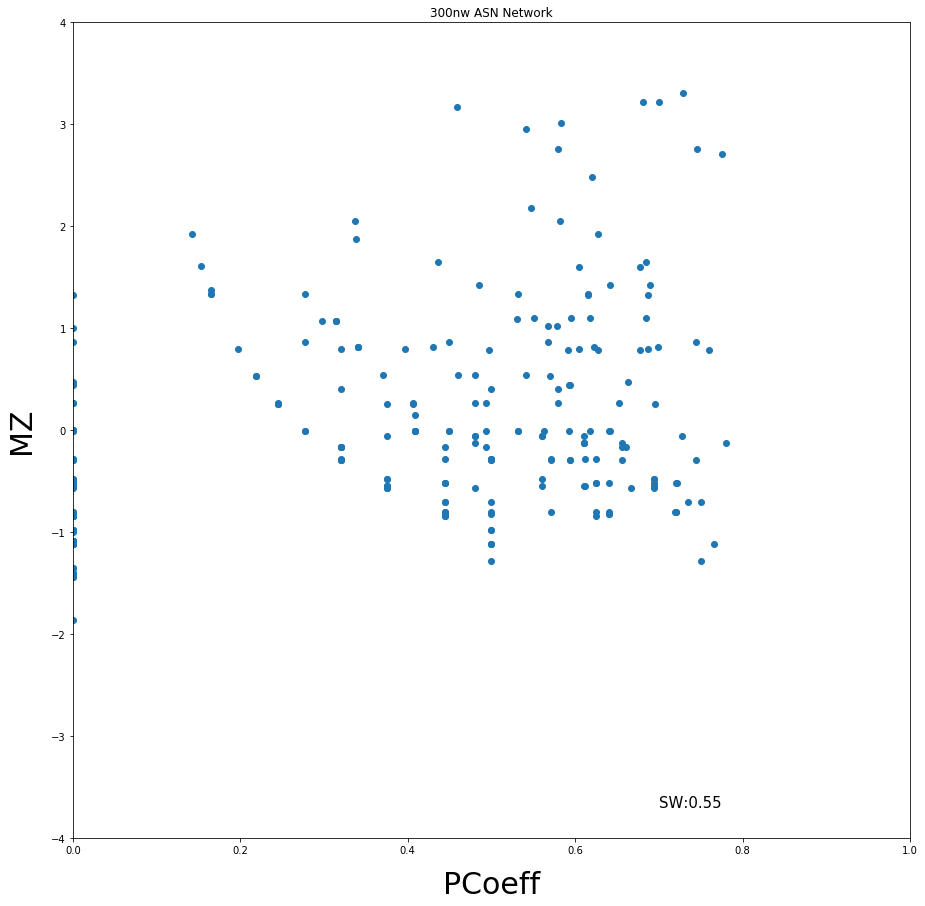

In [42]:
fig1=plt.figure(figsize=(15,15))

plt.title('300nw ASN Network')
plt.xlabel('PCoeff',fontsize=30,labelpad=15)
plt.ylabel('MZ',fontsize=30,labelpad=15)
plt.scatter(pcoeff,mz)
plt.text(0.7,-3.7,'SW:'+"{0:.2f}".format(smallworld[0]),fontsize=15)
plt.ylim(-4,4)
plt.xlim(0,1)

# Task 1: Linear  Transformation

In [28]:
#Regression
def NOKEVregression(target,absV): 
    inputx=np.vstack((np.ones(len(target)),absV)).T
    a1=np.linalg.lstsq(inputx,target)
    return a1

## ASN Networks:

In [105]:
#Instantiate Variables       
stimulus=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
onAmp=[1.5,2,4,4,6,6,8,6,6,6,6,6,4,4,4,4,6,4,4,4,4,3,2,1.5]

#Choose Electrode Pattern
for i in range(len(onAmp)):
    stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    
#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results=[None]*len(ASN300)
# Voltage=[None]*len(ASN300)
# Switches=[None]*len(ASN300)


nwSqu = [None]*len(ASN300)

#Run Simulations
for i in range(len(ASN300)): #for each network
    print('Network ' + str(i))
    #Run Simulations
#     results=[]
    # Connectivity=connectivity__('700nw_14533junctions.mat')
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#     set_trace()
    results[i]=runSim(connectivity__(wires_dict=ASN300[i]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp[i], biasType='AC',f=f,junctionMode='tunneling')
    #wires_dict=newNetworkTest[chosenNetwork])
    results[i].frequency=f
    results[i].dt=0.001
    period=1/f

    TimeVector=results[i].TimeVector
    voltage=results[i].wireVoltage
    conductance=results[i].conductance
    switches=results[i].junctionSwitch

    stepNodes=len(ASN300[i])-1 #first use all nodes
    sizes2=len(ASN300[i])
    nwOutputs = [None]* int(sizes2/stepNodes)
            
    outputNodes2=[]

    for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
        np.random.seed(69)

        outputNodes2.append(voltage[:,np.random.choice(len(voltage[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes

        nwOutputs=outputNodes2 #Length of nwOutputs is k (list)

    target1=[None]*len(nwOutputs)
    target2=[None]*len(nwOutputs)
    target3=[None]*len(nwOutputs)
    target4=[None]*len(nwOutputs)
    target5=[None]*len(nwOutputs)

    for j in range(len(nwOutputs)):
        target1[j] = (onAmp[i] * (-np.sign(TimeVector % period - period/2)))
        target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
        target3[j] = (onAmp[i]/period * (TimeVector % period))
        target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))


#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]

    ResultSqu=[]
#        ResultTri=[]
#        ResultSaw=[]
    accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
    output=[]
    mSqu=[]
#        mTri=[]
#        mSaw=[]
#        mDbl=[]

    for j in range(len(nwOutputs)): #for each output
        ResultSqu=NOKEVregression(target1[j],nwOutputs[j].T)[0]
        outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
        temp=np.dot(outputx,ResultSqu)
        MSE=np.mean((target1[j]-temp)**2)
        rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
        nwSqu[i]=(1 - rnMSE)
#         set_trace()

Running Simulation :   0%|                                                                    | 0/5000 [00:00<?, ?it/s]

Network 0


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 731.72it/s]
2020-03-11 14:40:58,421:INFO:First current path [3, 270, 186, 50, 26, 110] formed at time = 0.539 s.
Running Simulation :   2%|█                                                         | 89/5000 [00:00<00:05, 860.60it/s]

Network 1


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 833.26it/s]
2020-03-11 14:41:04,892:INFO:First current path [202, 225, 68, 52, 222, 235, 133, 69, 81, 271, 132] formed at time = 0.877 s.
Running Simulation :   2%|▉                                                         | 82/5000 [00:00<00:06, 814.06it/s]

Network 2


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1044.33it/s]
2020-03-11 14:41:09,827:INFO:First current path [97, 281, 262, 116, 250, 196, 34, 99, 79, 68, 288, 201, 181] formed at time = 0.52 s.
Running Simulation :   2%|█                                                         | 90/5000 [00:00<00:05, 893.48it/s]

Network 3


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1102.64it/s]
2020-03-11 14:41:14,578:INFO:First current path [147, 177, 150, 223, 239, 136, 117, 154, 191, 113, 137, 267, 159, 66, 281, 196, 218, 204, 28, 109, 55] formed at time = 0.837 s.
Running Simulation :   3%|█▍                                                      | 133/5000 [00:00<00:03, 1320.37it/s]

Network 4


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1251.32it/s]
2020-03-11 14:41:18,666:INFO:First current path [74, 213, 41, 252, 101, 98, 87, 143, 178, 6, 102, 175, 173, 192, 26, 179, 168, 54, 155, 134, 27, 139, 165, 136, 127] formed at time = 0.632 s.
Running Simulation :   3%|█▌                                                      | 143/5000 [00:00<00:03, 1419.64it/s]

Network 5


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1517.91it/s]
2020-03-11 14:41:22,045:INFO:First current path [204, 191, 199, 40, 178, 78, 58, 84, 74, 121, 150, 185, 5, 88, 112, 147, 207, 177, 104, 86, 81, 102, 218, 8, 94, 108, 10, 33, 152, 27] formed at time = 0.75 s.
Running Simulation :   2%|▉                                                         | 81/5000 [00:00<00:06, 796.21it/s]

Network 6


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1339.17it/s]
2020-03-11 14:41:25,847:INFO:First current path [150, 125, 105, 24, 121, 19, 141, 48, 216, 116, 18, 94, 188, 185, 175, 223, 159, 92, 5, 201, 162, 129, 78, 88, 138, 25, 50, 107, 190, 215, 207, 60, 212, 172, 137, 208] formed at time = 0.67 s.
Running Simulation :   3%|█▍                                                      | 127/5000 [00:00<00:03, 1260.78it/s]

Network 7


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1391.75it/s]
2020-03-11 14:41:29,646:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   3%|█▋                                                      | 153/5000 [00:00<00:03, 1518.90it/s]

Unfortunately, only 0 current paths found in simulation time.
Network 8


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1345.29it/s]
2020-03-11 14:41:34,281:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   3%|█▌                                                      | 139/5000 [00:00<00:03, 1389.40it/s]

Unfortunately, only 0 current paths found in simulation time.
Network 9


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1417.60it/s]
2020-03-11 14:41:38,585:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▎                                                      | 121/5000 [00:00<00:04, 1201.26it/s]

Unfortunately, only 0 current paths found in simulation time.
Network 10


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1572.42it/s]
2020-03-11 14:41:41,842:INFO:First current path [204, 191, 199, 40, 178, 78, 58, 84, 74, 121, 150, 185, 5, 88, 112, 147, 207, 177, 104, 86, 81, 102, 218, 8, 94, 108, 10, 33, 152, 27] formed at time = 0.75 s.
Running Simulation :   3%|█▉                                                      | 169/5000 [00:00<00:02, 1677.76it/s]

Network 11


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1590.95it/s]
2020-03-11 14:41:45,695:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   4%|██                                                      | 184/5000 [00:00<00:02, 1826.65it/s]

Unfortunately, only 0 current paths found in simulation time.
Network 12


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2081.67it/s]
2020-03-11 14:41:48,145:INFO:First current path [58, 5, 137, 111, 68, 118, 31, 91, 173, 2, 120, 79, 35, 146, 6, 64, 55, 127, 144, 172, 156] formed at time = 0.764 s.
Running Simulation :   3%|█▋                                                      | 154/5000 [00:00<00:03, 1535.28it/s]

Network 13


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1464.12it/s]
2020-03-11 14:41:51,618:INFO:First current path [79, 83, 166, 50, 11, 55, 74, 106, 84, 30, 98, 68, 186, 192, 22, 9, 178, 8, 201, 37] formed at time = 0.716 s.
Running Simulation :   4%|██                                                      | 180/5000 [00:00<00:02, 1786.95it/s]

Network 14


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1688.95it/s]
2020-03-11 14:41:54,633:INFO:First current path [79, 130, 118, 149, 106, 157, 121, 133, 38, 128, 122, 158, 87, 136, 199] formed at time = 0.575 s.
Running Simulation :  14%|███████▌                                                | 679/5000 [00:00<00:01, 3391.40it/s]

Network 15


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3498.11it/s]
2020-03-11 14:41:56,092:INFO:First current path [2, 26, 37, 33, 49, 45] formed at time = 0.319 s.
Running Simulation :   3%|█▌                                                      | 139/5000 [00:00<00:03, 1379.93it/s]

Network 16


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1441.35it/s]
2020-03-11 14:41:59,637:INFO:First current path [204, 191, 199, 40, 178, 78, 58, 84, 74, 121, 150, 185, 5, 88, 112, 147, 207, 177, 104, 86, 81, 102, 218, 8, 94, 108, 10, 33, 152, 27] formed at time = 0.75 s.
Running Simulation :   3%|█▍                                                      | 130/5000 [00:00<00:03, 1290.57it/s]

Network 17


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1135.93it/s]
2020-03-11 14:42:04,143:INFO:First current path [129, 138, 167, 141, 207, 221, 85, 127, 108, 52, 115, 180, 224, 185, 197, 25, 253, 3, 101, 98] formed at time = 0.735 s.
Running Simulation :   3%|█▍                                                      | 132/5000 [00:00<00:04, 1141.96it/s]

Network 18


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1017.23it/s]
2020-03-11 14:42:09,186:INFO:First current path [149, 179, 152, 225, 195, 35, 236, 15, 165, 287, 32, 191, 173, 12, 89, 145, 196] formed at time = 0.638 s.
Running Simulation :   2%|█▏                                                      | 106/5000 [00:00<00:04, 1056.26it/s]

Network 19


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1040.46it/s]
2020-03-11 14:42:14,173:INFO:First current path [97, 281, 253, 132, 62, 98, 196, 117, 142, 273, 186, 288, 201, 181] formed at time = 0.568 s.
Running Simulation :   2%|█▎                                                      | 117/5000 [00:00<00:04, 1056.72it/s]

Network 20


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 983.18it/s]
2020-03-11 14:42:19,443:INFO:First current path [57, 84, 39, 175, 150, 166, 250, 116, 231, 281, 97] formed at time = 0.463 s.
Running Simulation :   2%|▉                                                         | 81/5000 [00:00<00:06, 807.60it/s]

Network 21


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 937.44it/s]
2020-03-11 14:42:25,047:INFO:First current path [132, 271, 209, 81, 152, 116, 253, 134, 76, 84, 57, 182] formed at time = 0.64 s.
Running Simulation :   2%|█                                                         | 90/5000 [00:00<00:05, 893.47it/s]

Network 22


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 844.15it/s]
2020-03-11 14:42:31,295:INFO:First current path [58, 65, 179, 21, 161, 116, 126, 272, 132] formed at time = 0.655 s.
Running Simulation :   2%|▉                                                         | 83/5000 [00:00<00:06, 781.73it/s]

Network 23


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 838.31it/s]
2020-03-11 14:42:39,717:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.


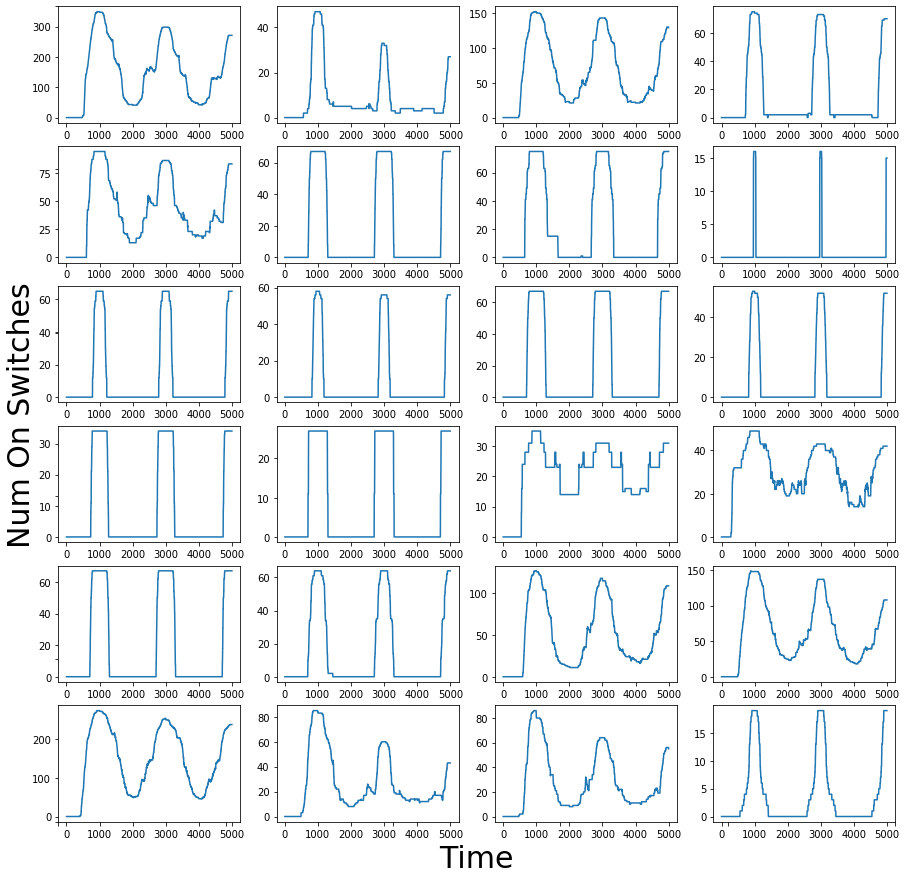

In [111]:
#network junctions switches:
fig1=plt.figure(figsize=(15,15))
ax=[None]*24
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xlabel('Time',fontsize=30,labelpad=15)
plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
for i in range(24):
    ax[i]=fig1.add_subplot(6, 4, i+1)
    plt.plot(np.sum(results[i].junctionSwitch,1))

In [114]:
#Linear Transform Accuracies:
for i in range(len(ASN300)):
    ASN300[i]['Accuracy']['Linear Transformation']=nwSqu[i]

## WS Networks

In [ ]:
#Instantiate Variables       
stimulus=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
onAmp=[2,2,4,8,8,10,10,10,10,10,10,10,8,8,8,8,8,8,8,4,4,3,2,1.5]

#Choose Electrode Pattern
for i in range(len(onAmp)):
    stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp[i],TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training
    
#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results_grid=[None]*len(ws300)
results_rand=[None]*len(ws300)

nwSqu_grid = [None]*len(ws300)
nwSqu_rand = [None]*len(ws300)
#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]


#Run Simulations
for i in range(len(ws300)): #for each network
    print('Network ' + str(i))
    #Run Simulations
#     results=[]
    # Connectivity=connectivity__('700nw_14533junctions.mat')
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#     set_trace()
    # GRID WS:
    print('Grid')
    results_grid[i]=runSim(connectivity__(graph=ws300[i][0]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp[i], biasType='AC',f=f,junctionMode='tunneling')
    # RANDOM WS:
    print('Random')
    results_rand[i]=runSim(connectivity__(graph=ws300[i][1]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp[i], biasType='AC',f=f,junctionMode='tunneling')
    # Small World WS:
    # 
    
    results_grid[i].frequency=f
    results_rand[i].frequency=f
    results_grid[i].dt=0.001
    results_rand[i].dt=0.001
    period=1/f

    TimeVector_grid=results_grid[i].TimeVector
    voltage_grid=results_grid[i].wireVoltage
    conductance_grid=results_grid[i].conductance
    switches_grid=results_grid[i].junctionSwitch
    
    TimeVector_rand=results_rand[i].TimeVector
    voltage_rand=results_rand[i].wireVoltage
    conductance_rand=results_rand[i].conductance
    switches_rand=results_rand[i].junctionSwitch

    stepNodes=len(ws300[i][0])-1 #first use all nodes
    sizes2=len(ws300[i][0])
    nwOutputs = [None]* int(sizes2/stepNodes)
            
    outputNodes2_grid=[]
    outputNodes2_rand=[]
    
    for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
        np.random.seed(69)

        outputNodes2_grid.append(voltage_grid[:,np.random.choice(len(voltage_grid[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes
        outputNodes2_rand.append(voltage_rand[:,np.random.choice(len(voltage_rand[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes
        nwOutputs_grid=outputNodes2_grid #Length of nwOutputs is k (list)
        nwOutputs_rand=outputNodes2_rand

    target1=[None]*len(outputNodes2_rand)
#     target2=[None]*len(nwOutputs)
#     target3=[None]*len(nwOutputs)
#     target4=[None]*len(nwOutputs)
#     target5=[None]*len(nwOutputs)

    for j in range(len(nwOutputs)):
        target1[j] = (onAmp[i] * (-np.sign(TimeVector_grid % period - period/2)))
#         target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
#         target3[j] = (onAmp[i]/period * (TimeVector % period))
#         target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))

    ResultSqu_grid=[]
    ResultSqu_rand=[]
#        ResultTri=[]
#        ResultSaw=[]
    accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
    output=[]

    for j in range(len(nwOutputs_grid)): #for each output
        ResultSqu_grid=NOKEVregression(target1[j],nwOutputs_grid[j].T)[0]
        ResultSqu_rand=NOKEVregression(target1[j],nwOutputs_rand[j].T)[0]
        
        outputx_grid=np.vstack((np.ones(len(target1[j])),nwOutputs_grid[j].T)).T
        outputx_rand=np.vstack((np.ones(len(target1[j])),nwOutputs_rand[j].T)).T
        
        temp=np.dot(outputx_grid,ResultSqu_grid)
        temp2=np.dot(outputx_rand,ResultSqu_rand)
        
        MSE=np.mean((target1[j]-temp)**2)
        MSE2=np.mean((target1[j]-temp2)**2)
        
        rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
        rnMSE2=np.sqrt(np.sum((target1[j]-temp2)**2)/np.sum((target1[j])**2))
        nwSqu_grid[i]=(1 - rnMSE)
        nwSqu_rand[i]=(1 - rnMSE2)
#         set_trace()

Running Simulation :   0%|                                                                    | 0/5000 [00:00<?, ?it/s]

Network 0
Grid


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 623.88it/s]
2020-03-11 15:00:00,414:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█                                                         | 91/5000 [00:00<00:05, 904.45it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 929.13it/s]
2020-03-11 15:00:05,920:INFO:First current path [0, 4, 126, 8] formed at time = 0.33 s.
Running Simulation :   2%|█▏                                                       | 100/5000 [00:00<00:04, 999.77it/s]

Network 1
Grid


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 987.71it/s]
2020-03-11 15:00:11,606:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   1%|▋                                                         | 59/5000 [00:00<00:08, 579.98it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 977.44it/s]
2020-03-11 15:00:16,832:INFO:First current path [18, 162, 170, 287, 26, 143] formed at time = 0.447 s.
Running Simulation :   2%|█▏                                                      | 110/5000 [00:00<00:04, 1092.02it/s]

Network 2
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1057.38it/s]
2020-03-11 15:00:21,822:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▏                                                       | 101/5000 [00:00<00:04, 992.84it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1082.49it/s]
2020-03-11 15:00:26,527:INFO:First current path [0, 220, 69, 225, 38, 271, 103, 298] formed at time = 0.36 s.
Running Simulation :   2%|█▏                                                      | 106/5000 [00:00<00:04, 1052.31it/s]

Network 3
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1173.40it/s]
2020-03-11 15:00:31,021:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   0%|                                                                    | 0/5000 [00:00<?, ?it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1014.35it/s]
2020-03-11 15:00:36,045:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.


Running Simulation :   2%|▉                                                         | 78/5000 [00:00<00:07, 692.71it/s]

Network 4
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1105.28it/s]
2020-03-11 15:00:41,063:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   3%|█▍                                                      | 130/5000 [00:00<00:04, 1150.86it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 986.50it/s]
2020-03-11 15:00:46,226:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.
Network 5
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1112.44it/s]
2020-03-11 15:00:50,949:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▎                                                      | 114/5000 [00:00<00:04, 1131.74it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1130.21it/s]
2020-03-11 15:00:55,444:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▏                                                      | 103/5000 [00:00<00:04, 1022.53it/s]

Network 6
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1070.14it/s]
2020-03-11 15:01:00,374:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▏                                                      | 107/5000 [00:00<00:04, 1059.51it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1050.78it/s]
2020-03-11 15:01:05,202:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▏                                                      | 111/5000 [00:00<00:04, 1077.74it/s]

Network 7
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1041.23it/s]
2020-03-11 15:01:10,287:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▏                                                        | 98/5000 [00:00<00:05, 977.87it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1145.53it/s]
2020-03-11 15:01:14,721:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▎                                                      | 121/5000 [00:00<00:04, 1201.23it/s]

Network 8
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1175.85it/s]
2020-03-11 15:01:19,200:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▏                                                      | 110/5000 [00:00<00:04, 1093.70it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1191.15it/s]
2020-03-11 15:01:23,465:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▎                                                      | 117/5000 [00:00<00:04, 1121.20it/s]

Network 9
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1155.92it/s]
2020-03-11 15:01:28,009:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▍                                                      | 124/5000 [00:00<00:03, 1231.01it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1094.80it/s]
2020-03-11 15:01:32,643:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▍                                                      | 123/5000 [00:00<00:03, 1221.08it/s]

Network 10
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1064.62it/s]
2020-03-11 15:01:37,606:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▏                                                       | 100/5000 [00:00<00:04, 992.75it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1060.25it/s]
2020-03-11 15:01:42,390:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▎                                                      | 118/5000 [00:00<00:04, 1171.44it/s]

Network 11
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1141.15it/s]
2020-03-11 15:01:47,019:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▎                                                      | 112/5000 [00:00<00:04, 1111.87it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1161.01it/s]
2020-03-11 15:01:51,404:INFO:First current path [105, 59, 255, 203, 233, 158, 250, 102, 41, 82, 100, 218, 109, 210, 205, 279, 276, 30, 182, 54, 32, 259, 228, 129, 187, 219, 47, 213, 108, 258, 197, 148, 288, 204, 293, 140, 113, 268, 97, 296, 178, 136, 160, 189, 88, 206, 7, 212] formed at time = 0.697 s.
Running Simulation :   2%|█▎                                                      | 118/5000 [00:00<00:04, 1171.44it/s]

Network 12
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1175.70it/s]
2020-03-11 15:01:55,900:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   3%|█▍                                                      | 126/5000 [00:00<00:03, 1250.87it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1153.45it/s]
2020-03-11 15:02:00,331:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.
Network 13
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1090.43it/s]
2020-03-11 15:02:05,170:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   3%|█▍                                                      | 129/5000 [00:00<00:04, 1137.29it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1204.66it/s]
2020-03-11 15:02:09,407:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.
Network 14
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1195.84it/s]
2020-03-11 15:02:13,822:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|▉                                                         | 85/5000 [00:00<00:05, 843.86it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 927.17it/s]
2020-03-11 15:02:19,319:INFO:Unfortunately, no current path is formed in simulation time.


Unfortunately, only 0 current paths found in simulation time.
Network 15
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1129.61it/s]
2020-03-11 15:02:24,015:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|█▍                                                      | 124/5000 [00:00<00:03, 1231.01it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1218.27it/s]
2020-03-11 15:02:28,215:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   0%|                                                                    | 0/5000 [00:00<?, ?it/s]

Unfortunately, only 0 current paths found in simulation time.
Network 16
Grid


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1218.98it/s]
2020-03-11 15:02:32,550:INFO:Unfortunately, no current path is formed in simulation time.
Running Simulation :   2%|▉                                                         | 86/5000 [00:00<00:05, 853.76it/s]

Unfortunately, only 0 current paths found in simulation time.
Random


Running Simulation :  27%|██████████████▉                                        | 1356/5000 [00:01<00:03, 1124.91it/s]

### Unpacking Simulations (WS)

NameError: name 'results_rand' is not defined

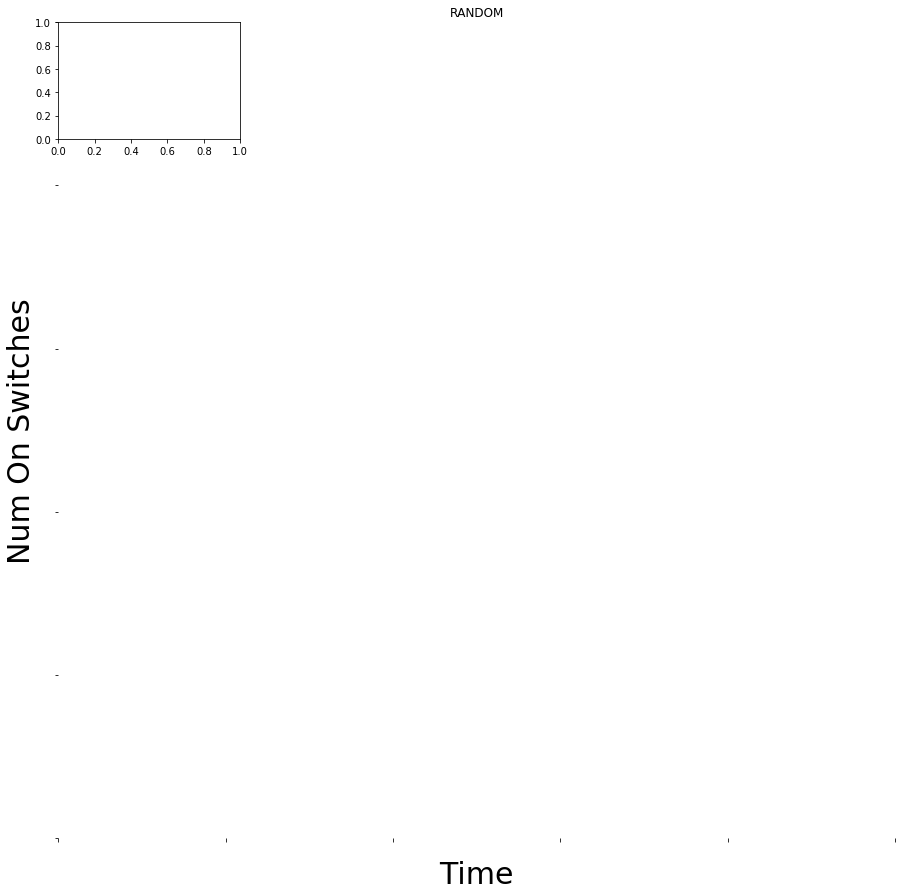

In [26]:
#network junctions switches:
fig1=plt.figure(figsize=(15,15))
plt.title('RANDOM')
ax=[None]*24
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xlabel('Time',fontsize=30,labelpad=15)
plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
for i in range(24):
    ax[i]=fig1.add_subplot(6, 4, i+1)
    plt.plot(np.sum(results_rand[i].junctionSwitch,1))

Text(0, 0.5, 'Num On Switches')

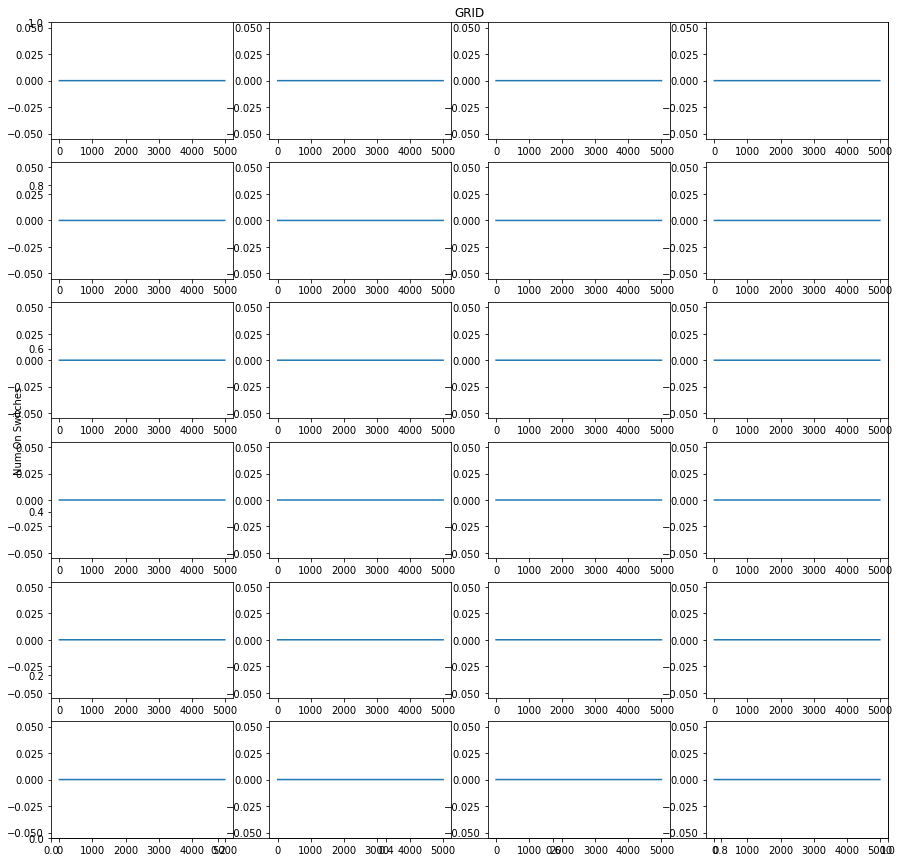

In [47]:
#network junctions switches:
fig1=plt.figure(figsize=(15,15))
plt.title('GRID')
ax=[None]*24
axBig = fig1.add_subplot(111)
axBig.set_frame_on(False)
axBig.set_yticklabels([])
axBig.set_xticklabels([])
plt.xlabel('Time',fontsize=30,labelpad=15)
plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
for i in range(24):
    ax[i]=fig1.add_subplot(6, 4, i+1)
    plt.plot(np.sum(results_grid[i].junctionSwitch,1))

In [49]:
nwSqu_grid

[0.6977258439119274,
 0.6677484947384543,
 0.6472371669830066,
 0.5701893818177167,
 0.5701893818177167,
 0.5690727933432619,
 0.5690727933432619,
 0.5690727933432619,
 0.5690727933432619,
 0.5690727933432619,
 0.5690727933432619,
 0.5690727933432619,
 0.5701893818177167,
 0.5701893818177167,
 0.5701893818177167,
 0.5701893818177167,
 0.5701893818177167,
 0.5701893818177167,
 0.6755374236941325,
 0.6472371669830066,
 0.6697755867643358,
 0.6720607446485161,
 0.6815123532940645,
 0.6881710919871199]

In [50]:
nwSqu_rand

[0.7966455088699532,
 0.8082163760606584,
 0.7684570588868025,
 0.5773964708345893,
 0.5773964708345893,
 0.5753480272208391,
 0.5753480272208391,
 0.5753480272208391,
 0.5753480272208391,
 0.5753480272208391,
 0.5753480272208391,
 0.5753480272208391,
 0.5773964708345893,
 0.5773964708345893,
 0.5773964708345893,
 0.5773964708345893,
 0.5773964708345893,
 0.5773964708345893,
 0.7167819840055969,
 0.7684570588868025,
 0.7292591771615411,
 0.7943827904356788,
 0.7707247871170669,
 0.8296225989223545]

## C. Elegans

In [53]:
#Instantiate Variables       
stimulus=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
onAmp=2#[1.5,2,4,4,4,6,6,6,6,6,6,6,4,4,4,4,6,4,4,4,4,3,2,1.5]

#Choose Electrode Pattern

stimulus[0].append((stimulus__(biasType='AC',onAmp=onAmp,TimeVector=np.arange(0,Time,dt),f=f)))
stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results=[None]*len([elegansGraph])
# Voltage=[None]*len(ASN300)
# Switches=[None]*len(ASN300)


nwSqu = [None]*len([elegansGraph])

#Run Simulations
# for i in range(len(ASN300)): #for each network
print('Network C.Elegans')
#Run Simulations
#     results=[]
# Connectivity=connectivity__('700nw_14533junctions.mat')
stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#     set_trace()
results=runSim(connectivity__(graph=elegansGraph),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp, biasType='AC',f=f,junctionMode='tunneling')
#wires_dict=newNetworkTest[chosenNetwork])
results.frequency=f
results.dt=0.001
period=1/f

TimeVector=results.TimeVector
voltage=results.wireVoltage
conductance=results.conductance
switches=results.junctionSwitch

stepNodes=len(elegansGraph)-1 #first use all nodes
sizes2=len(elegansGraph)
nwOutputs = [None]* int(sizes2/stepNodes)

outputNodes2=[]

for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
    np.random.seed(69)

    outputNodes2.append(voltage[:,np.random.choice(len(voltage[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes

    nwOutputs=outputNodes2 #Length of nwOutputs is k (list)

target1=[None]*len(nwOutputs)
#     target2=[None]*len(nwOutputs)
#     target3=[None]*len(nwOutputs)
#     target4=[None]*len(nwOutputs)
#     target5=[None]*len(nwOutputs)

for j in range(len(nwOutputs)):
    target1[j] = (onAmp * (-np.sign(TimeVector % period - period/2)))
#         target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
#         target3[j] = (onAmp[i]/period * (TimeVector % period))
#         target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))


#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]

ResultSqu=[]
#        ResultTri=[]
#        ResultSaw=[]
accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
output=[]
mSqu=[]
#        mTri=[]
#        mSaw=[]
#        mDbl=[]

for j in range(len(nwOutputs)): #for each output
    ResultSqu=NOKEVregression(target1[j],nwOutputs[j].T)[0]
    outputx=np.vstack((np.ones(len(target1[j])),nwOutputs[j].T)).T
    temp=np.dot(outputx,ResultSqu)
    MSE=np.mean((target1[j]-temp)**2)
    rnMSE=np.sqrt(np.sum((target1[j]-temp)**2)/np.sum((target1[j])**2))
    nwSqu=(1 - rnMSE)
#         set_trace()

Running Simulation :   2%|█▎                                                      | 119/5000 [00:00<00:04, 1181.71it/s]

Network C.Elegans


Running Simulation : 100%|███████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1198.75it/s]
2020-03-11 11:30:58,895:INFO:First current path [9, 38, 16, 169, 105, 98, 36] formed at time = 0.509 s.


In [54]:
nwSqu

0.8120490161284999

# Mackey Glass

In [ ]:
def runForecastNew(connectivity, multi = 1, shift = 0, 
                training_ratio = 0.3, past_steps = 50,
                cheat_period = 100, cheat_steps = 60,
                save_fig = False,
                disable_tqdm = False,inList = 0, outList=0):

    N = connectivity.numOfWires
    inList = inList#np.argsort(connectivity.xa)[0:20]
    outList = outList#np.argsort(connectivity.xb)[::-1][0:20]
    
    theMat = np.zeros((N+2, N+2))
    theMat[0:N, 0:N] = connectivity.adj_matrix
    theMat[N, inList] = 1
    theMat[inList, N] = 1
    theMat[N+1, outList] = 1
    theMat[outList, N+1] = 1
    theGraph = nx.from_numpy_array(theMat)
    
    Connectivity = connectivity__(graph = theGraph)
    # junctionList = [findJunctionIndex(Connectivity, N+1, i) for i in outList]
    
    SimulationOptions = simulationOptions__(dt = 1e-2, T = 100,
                                        contactMode = 'preSet',
                                        electrodes = [N, N+1])
    signal = mkg_generator(10000, tau = 18, a = 0.2, b = 0.1, dt = 0.1)*multi+shift
    SimulationOptions.stimulus[0] = stimulus__(biasType = 'Custom', TimeVector = SimulationOptions.TimeVector, customSignal = signal)
    JunctionState = junctionState__(Connectivity.numOfJunctions, mode = 'binary', collapse = True)

    sim1, weight1, measure1 = forecast(SimulationOptions, Connectivity, JunctionState,
                                   training_ratio, past_steps, forecast_on = True, measure_type = 'voltage', 
                                   past_signal = True, pre_activate = False, 
                                   cheat_on = True, cheat_period = cheat_period, cheat_steps = cheat_steps,
                                   update_weight = False, update_stepsize = 100, disable_tqdm = disable_tqdm)
    
    RNMSE = getRNMSE(sim1.forecast[sim1.predict_index]-shift, sim1.stimulus[0].signal[sim1.predict_index]-shift)
    sim1.forecastParams = dict(numOfWires = sim1.numOfWires,
                                numOfJunctions = sim1.numOfJunctions,
                                multi = multi, shift = shift,
                                training_ratio = training_ratio,
                                past_steps = past_steps,
                                cheat_period = cheat_period,
                                forecast_steps = cheat_period - cheat_steps,
                                cheat_steps = cheat_steps)
    if save_fig and (RNMSE < 0.5):
        plt.figure()
        plotForecastPanel(sim1)
        import time
        filename = time.strftime("%Y-%m-%d-%H%M%S") + '_RNMSE_' + str(np.round(RNMSE, 4)) + '.png'
        plt.savefig(filename)
    
    logging.info(f'RNMSE = {RNMSE}')
    return RNMSE


In [ ]:
accuracy={'ASN300':[None]*len(ASN300),'Elegans':[],'WS Grid 300':[None]*len(ASN300),'WS Random 300':[None]*len(ASN300)}

## 100nw & 300nw ASNs

In [ ]:
ASN_con_300=[None]*len(ASN300)
for i in range(len(ASN300)):
    ASN_con_300[i]=connectivity__(wires_dict=ASN300[i])   
# ASN_con_100=connectivity__(wires_dict=ASN100)   

In [ ]:
mse300=[None]*len(ASN_con_300)
for i in range(len(ASN_con_300)):
    print('Network ' + str(i))
    mse300[i]=runForecast(ASN_con_300[i], multi = 1, shift = 0, 
                    training_ratio = 0.3, past_steps = 50,
                    cheat_period = 100, cheat_steps = 60,
                    save_fig = False,
                    disable_tqdm = False)

In [ ]:
# mse100=runForecast(ASN_con_100, multi = 1, shift = 0, 
#                 training_ratio = 0.3, past_steps = 50,
#                 cheat_period = 100, cheat_steps = 50,
#                 save_fig = False,
#                 disable_tqdm = False)

In [ ]:
# accuracy['ASN100']=1-mse100
for i in range(len(mse300)):
    accuracy['ASN300'][i]=1-mse300[i]

In [ ]:
#Find best performing network:
best_params_nw=np.argsort(mse300) #sort by lowest MSE
best_accuracies=np.array(accuracy['ASN300'])[np.array(best_params_nw)] #define best accuracies based on lowest MSE

In [ ]:
sortedASN300=[]
for nw in best_params_nw:
    sortedASN300.append(ASN300[nw]) #make new list sorted by highest to lowest accuracy

In [ ]:
best_accuracies

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx(sortedASN300[0]['G'])

## C. Elegans

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx(elegansGraph)

In [ ]:
mseElegans=runForecastNew(connectivity__(graph=elegansGraph), multi = 1, shift = 0, 
                training_ratio = 0.3, past_steps = 50,
                cheat_period = 100, cheat_steps = 60,
                save_fig = False,
                disable_tqdm = False, inList=8, outList=245)

In [ ]:
accuracy['Elegans']=1-mseElegans

## Watts-Strogatz
### Grid & Random

In [ ]:
ws300[10][1].number_of_nodes()

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx(ws300[10][1])

In [ ]:
# mseGrid100=runForecastNew(connectivity__(graph=ws100[0]), multi = 1, shift = 0, 
#                 training_ratio = 0.3, past_steps = 50,
#                 cheat_period = 100, cheat_steps = 60,
#                 save_fig = False,
#                 disable_tqdm = False,inList=0,outList=75)

In [ ]:
# mseRandom100=runForecastNew(connectivity__(graph=ws100[1]), multi = 1, shift = 0, 
#                 training_ratio = 0.3, past_steps = 50,
#                 cheat_period = 100, cheat_steps = 50,
#                 save_fig = False,
#                 disable_tqdm = False,inList=54,outList=25)

In [ ]:
mseGrid300=[None]*len(ws300)
for i in range(len(ws300)):
    print('Network ' + str(i))
    numNodes=ws300[i][0].number_of_nodes()
    mseGrid300[i]=runForecastNew(connectivity__(graph=ws300[i][0]), multi = 1, shift = 0, 
                    training_ratio = 0.3, past_steps = 50,
                    cheat_period = 100, cheat_steps = 60,
                    save_fig = False,
                    disable_tqdm = False,inList=0,outList=int(numNodes/2))

In [ ]:
mseRandom300=[None]*len(ws300)

for i in range(len(ws300)):
    adjmat=np.asarray(nx.adjacency_matrix(ws300[i][1]).todense())
    electrodes=edamame.core.getFarthestpairing(adjmat)
#     numNodes=ws300[i][1].number_of_nodes()
    mseRandom300[i]=runForecastNew(connectivity__(graph=ws300[i][0]), multi = 1, shift = 0, 
                training_ratio = 0.3, past_steps = 50,
                cheat_period = 100, cheat_steps = 60,
                save_fig = False,
                disable_tqdm = False,inList=electrodes[0],outList=electrodes[1])

In [ ]:
#Find best performing networks: (Random)
for i in range(len(mse300)):
    accuracy['WS Random 300'][i]=1-mseRandom300[i]
    
best_params_random=np.argsort(mseRandom300) #sort by lowest MSE
best_accuracies_random=np.array(accuracy['WS Random 300'])[np.array(best_params_random)] #define best accuracies based on lowest MSE

sortedRandom=[]
for nw in best_params_random:
    sortedRandom.append(ws300[nw][1]) #make new list sorted by highest to lowest accuracy



#Find best performing networks: (Grid)

for i in range(len(mse300)):
    accuracy['WS Grid 300'][i]=1-mseGrid300[i]
    
best_params_grid=np.argsort(mseGrid300) #sort by lowest MSE
best_accuracies_grid=np.array(accuracy['WS Grid 300'])[np.array(best_params_grid)] #define best accuracies based on lowest MSE

sortedGrid=[]
for nw in best_params_grid:
    sortedGrid.append(ws300[nw][1]) #make new list sorted by highest to lowest accuracy

print('WS Grid Accuracies: ' + str(accuracy['WS Grid 300']))
print('WS Random Accuracies: ' + str(accuracy['WS Random 300']))

In [ ]:
best_params_grid

In [ ]:
best_params_random

In [ ]:
# accuracy['WS Grid 100']=1-mseGrid100
# accuracy['WS Random 100']=1-mseRandom100
for i in range(len(mseRandom300)):
    accuracy['WS Grid 300'][i]=1-mseGrid300[i]
    accuracy['WS Random 300'][i]=1-mseRandom300[i]

In [ ]:
accuracy

In [ ]:
plt.plot(accuracy['ASN300'],label='300nw ASN')
plt.hlines(accuracy['Elegans'],xmin=0,xmax=23,label='C. Elegans')
plt.plot(accuracy['WS Grid 300'],label='WS Grid')
plt.plot(accuracy['WS Random 300'],label='WS Random')
plt.yscale('log')
plt.legend(loc='lower right')